# US Accident

## Contexte

Nous constatons qu'il y a beaucoup d'accidents de voiture dans le monde. Les Etats-Unis n'échappe pas à la règle avec plusieurs milliers d'accidents dans le monde. Ainsi, nous allons nous poser 2 questions :
    <ul>
    <li>Quelles sont les régions les plus touchées par les accidents de voitures</li>
    <li>En cas d'accidents, quelles s'étaient les gravitées des accidents</li>
    </ul>
    
Nous allons égalements chercher à comprendre quelles sont les causes de ces accidents.

## Liens utiles

Telechargement de la liste des colonnes du Dataset :
   <a href="https://github.com/alphab2000x/python/blob/master/Master2/Projet5/Liste_des_colonnes.docx?raw=true">Liste_des_colonnes.docx</a>
    
Rapport :

## Import

In [1111]:
import seaborn as sns;
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as TTS
from sklearn.model_selection import cross_val_score;
from sklearn.preprocessing import LabelEncoder;
from sklearn.ensemble import RandomForestClassifier

# pipeline elements
from sklearn.decomposition import PCA # PCA = Principal Component Analysis
from sklearn.neighbors import KNeighborsClassifier as KNN 

# pipeline materiaux
from sklearn.pipeline import Pipeline # PCA = Principal Component Analysis
from sklearn.model_selection import GridSearchCV

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from itertools import cycle


## Fonction

In [1112]:
# Créer une mesure de performance

def accuracy(preds, target):
    M = target.shape[0] # Nombre d'exemple
    total_correctes = (preds == target).sum()
    accuracy = total_correctes / M
    return accuracy

In [1113]:
# Afficher la matrice de confusion

def show_cm(cm, labels):
    df_cm = pd.DataFrame(cm, labels, labels)
    sns.heatmap(df_cm, annot=True)
    plt.show()

## Collecte de données

Nous allons étudier un dataset qui regroupent un enssemble d'accidents de voitures ayant eu lieu aux états-unis, soit dans 49 états. Les données ont été récoltées entre 2016 et 2020. Initialement, le dataset faisait environ 3500000 lignes mais étant données sa taille, il a été décider de la réduire afin de ne pas réduire les performances de calculs de nos algorithmes. 

In [1114]:
# On récupère notre Dataset et la stocke dans une variable

accident = pd.read_csv('data/US_Accidents_June20_mini.csv')

In [1115]:
accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 50 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             100000 non-null  int64  
 1   ID                     100000 non-null  object 
 2   Source                 100000 non-null  object 
 3   TMC                    70472 non-null   float64
 4   Severity               100000 non-null  int64  
 5   Start_Time             100000 non-null  object 
 6   End_Time               100000 non-null  object 
 7   Start_Lat              100000 non-null  float64
 8   Start_Lng              100000 non-null  float64
 9   End_Lat                29528 non-null   float64
 10  End_Lng                29528 non-null   float64
 11  Distance(mi)           100000 non-null  float64
 12  Description            100000 non-null  object 
 13  Number                 35363 non-null   float64
 14  Street                 100000 non-nul

In [1116]:
accident.head()

,Unnamed: 0,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,1901733,A-1901773,MapQuest,201.0,3,2018-05-20 12:33:29,2018-05-20 13:03:01,30.266512,-82.753860,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day
1,2923127,A-2923261,Bing,NaN,3,2020-04-19 01:54:45,2020-04-19 02:24:45,38.367280,-90.384540,38.36728,...,False,False,False,False,False,False,Night,Night,Night,Night
2,323307,A-323310,MapQuest,201.0,2,2017-02-08 12:29:23,2017-02-08 12:59:01,34.000233,-84.067162,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day
3,820712,A-820738,MapQuest,201.0,2,2019-10-15 09:28:51,2019-10-15 10:28:40,35.895634,-78.616295,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day
4,2084795,A-2084835,MapQuest,201.0,2,2018-02-18 11:16:29,2018-02-18 11:45:23,36.679970,-78.176910,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day


## Feature Engineering

Nous allons dans cette partie définir les colonnes/features et la target puis isoler les features de target.

In [1117]:
# On supprime les colonnes qui nous intéressent pas

accident = accident.drop(['ID'],axis=1)
accident = accident.drop(['Start_Lat'],axis=1)
accident = accident.drop(['Start_Lng'],axis=1)
accident = accident.drop(['End_Lat'],axis=1)
accident = accident.drop(['End_Lng'],axis=1)
accident = accident.drop(['Description'],axis=1)
accident = accident.drop(['Number'],axis=1)
accident = accident.drop(['Street'],axis=1)
accident = accident.drop(['Side'],axis=1)
accident = accident.drop(['Zipcode'],axis=1)
accident = accident.drop(['Country'],axis=1)
accident = accident.drop(['Timezone'],axis=1)
accident = accident.drop(['Weather_Timestamp'],axis=1)
accident = accident.drop(['Wind_Direction'],axis=1)
accident = accident.drop(['Wind_Chill(F)'],axis=1)

In [1118]:
accident = accident.dropna(how='any')

In [1119]:
# On va séparer notre target de nos colonnes

Y = accident['Severity'].astype('category').cat.codes # La target va être la gravité
X = accident.drop('Severity', axis='columns') # En fonction des critère environnant, on va essayer de prédir le niveau de gravité

In [1120]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25482 entries, 3 to 99994
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             25482 non-null  int64  
 1   Source                 25482 non-null  object 
 2   TMC                    25482 non-null  float64
 3   Start_Time             25482 non-null  object 
 4   End_Time               25482 non-null  object 
 5   Distance(mi)           25482 non-null  float64
 6   City                   25482 non-null  object 
 7   County                 25482 non-null  object 
 8   State                  25482 non-null  object 
 9   Airport_Code           25482 non-null  object 
 10  Temperature(F)         25482 non-null  float64
 11  Humidity(%)            25482 non-null  float64
 12  Pressure(in)           25482 non-null  float64
 13  Visibility(mi)         25482 non-null  float64
 14  Wind_Speed(mph)        25482 non-null  float64
 15  Pr

In [1121]:
# On convertie nos column date de type object en type date

X['Start_Time'] = pd.to_datetime(X['Start_Time'], 
 format = '%Y-%m-%d %H:%M:%S', 
 errors = 'coerce')
X['End_Time'] = pd.to_datetime(X['End_Time'], 
 format = '%Y-%m-%d %H:%M:%S', 
 errors = 'coerce')

In [1122]:
# On créé une colonne pour chaque élément de nos dates de début d'accident

X['Start_Time_year'] = X['Start_Time'].dt.year
X['Start_Time_month'] = X['Start_Time'].dt.month
X['Start_Time_week'] = X['Start_Time'].dt.week
X['Start_Time_day'] = X['Start_Time'].dt.day
X['Start_Time_hour'] = X['Start_Time'].dt.hour
X['Start_Time_minute'] = X['Start_Time'].dt.minute
X['Start_Time_dayofweek'] = X['Start_Time'].dt.dayofweek

In [1123]:
# On créé une colonne pour chaque élément de nos dates de fin d'accident

X['End_Time_year'] = X['End_Time'].dt.year
X['End_Time_month'] = X['End_Time'].dt.month
X['End_Time_week'] = X['End_Time'].dt.week
X['End_Time_day'] = X['End_Time'].dt.day
X['End_Time_hour'] = X['End_Time'].dt.hour
X['End_Time_minute'] = X['End_Time'].dt.minute
X['End_Time_dayofweek'] = X['End_Time'].dt.dayofweek

In [1124]:
# Maintenant que l'on a créé nos colonnes, on supprime nos de base vue que l'on en a plus besoin

X = X.drop(['Start_Time'],axis=1)
X = X.drop(['End_Time'],axis=1)

In [1125]:
# On convertie les colonnes dans le type qui nous interessent

X['Source'] = LabelEncoder().fit_transform(X['Source'])

X.TMC = X['TMC'].astype('category').cat.codes

X.City = X['City'].astype('category').cat.codes

X.State = X['State'].astype('category').cat.codes

X.County = X['County'].astype('category').cat.codes

X.Airport_Code = X['Airport_Code'].astype('category').cat.codes

X.Sunrise_Sunset = X['Sunrise_Sunset'].astype('category').cat.codes 

X.Weather_Condition = X['Weather_Condition'].astype('category').cat.codes

X.Nautical_Twilight = X['Nautical_Twilight'].astype('category').cat.codes

X.Astronomical_Twilight = X['Astronomical_Twilight'].astype('category').cat.codes

X.Civil_Twilight = X['Civil_Twilight'].astype('category').cat.codes

X['Amenity'] = LabelEncoder().fit_transform(X['Amenity'])
X['Bump'] = LabelEncoder().fit_transform(X['Bump'])
X['Crossing'] = LabelEncoder().fit_transform(X['Crossing'])
X['Give_Way'] = LabelEncoder().fit_transform(X['Give_Way'])
X['Junction'] = LabelEncoder().fit_transform(X['Junction'])
X['No_Exit'] = LabelEncoder().fit_transform(X['No_Exit'])
X['Railway'] = LabelEncoder().fit_transform(X['Railway'])
X['Roundabout'] = LabelEncoder().fit_transform(X['Roundabout'])
X['Station'] = LabelEncoder().fit_transform(X['Station'])
X['Stop'] = LabelEncoder().fit_transform(X['Stop'])
X['Traffic_Calming'] = LabelEncoder().fit_transform(X['Traffic_Calming'])
X['Traffic_Signal'] = LabelEncoder().fit_transform(X['Traffic_Signal'])
X['Turning_Loop'] = LabelEncoder().fit_transform(X['Turning_Loop'])

In [1126]:
# On enlève toutes les valeurs NaN

X = X.dropna(how='any')

In [1127]:
X.shape, Y.shape

((25482, 46), (25482,))

## Affichage des accidents en fonction des états

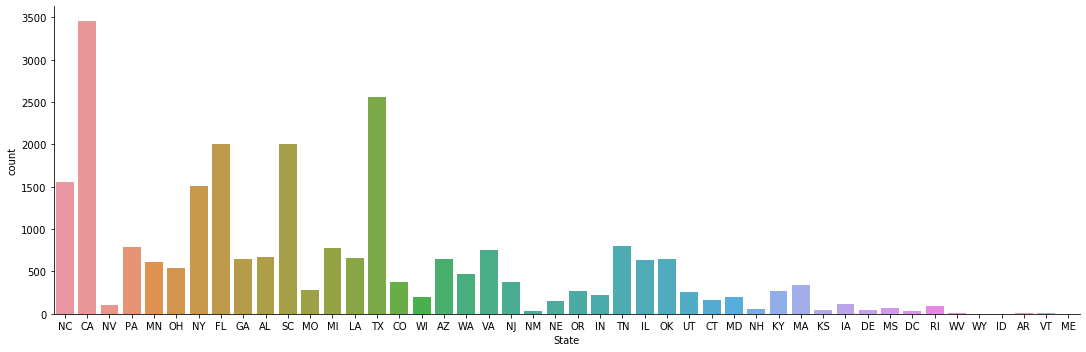

In [1128]:
sns.catplot(x='State', kind='count',data=accident, height=5, aspect=3) 

Nous pouvons voir dans le diagramme ci-dessus que certains états on beaucoup plus d'accidents que d'autres. En l'occurence:
<ul>
    <li>La Californie (CA) avec 3458 accidents</li>
    <li>Le Texas (TX) avec 2557 accidents</li>
    <li>La Floride (FL) avec 2010 accidents</li>
    <li>La Caroline du Sud (SC) avec 2006 accidents</li>
    <li>La Caroline du Nord (NC) avec 1555 accidents</li>
    <li>New York (NY) avec 1507 accidents</li>
</ul>

ont beaucoup plus d'accidents que la pluparts des autres pays. Nous allons essayer de savoir la raison de celà.

## Etude et corrélation

Nous allons essayé de voir si certaines features ne sont pas corrélé.

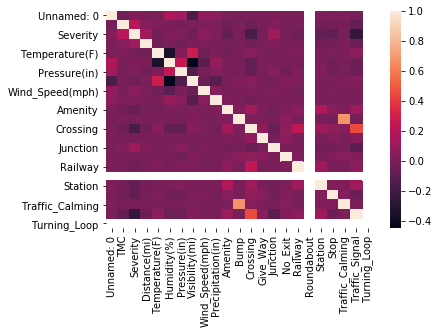

In [1150]:
corr = sns.heatmap(accident.corr())

Nous pouvons voir que la feature Roundabout soit la présence de rond-point est fortement corrélé à toutes les autres features. Notre objectif et alors, de voir si le nombre de rond-point dans une ville n'a pas un lien avec le nombre d'accident.

## Nombre de rond-point par Etat

In [1153]:
accident.Roundabout.unique()

array([False])

In [1151]:
#accident_wo_class0 = accident[accident['class'] == 1]              # On s'interessera qu'au fraude qui on eu lieu
state_by_roundabout = pd.DataFrame()                         # On crée un nouveau dataframe
state_by_roundabout['State'] = accident['State']            # On ajoute à notre dataset la colonne country
state_by_roundabout['Roundabout'] = accident['Roundabout']                # On ajoute à notre dataset la colonne classe
total = state_by_roundabout.groupby(by="State",as_index=False).sum().sort_values(by='Roundabout', ascending=False) # On groupe tout nos country en en fonction de la somme de nos class par ordre décroissant

#total.head(10)                                            # On affiche le total


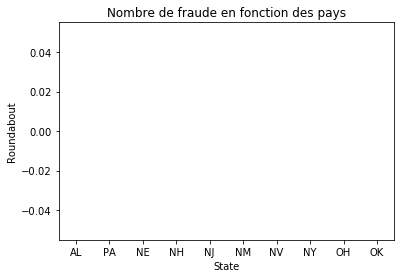

In [1152]:
df = total.head(10)

sns.barplot(df['State'], df['Roundabout']).set_title("Nombre de fraude en fonction des pays");

In [ ]:
#accident_wo_class0 = accident[accident['class'] == 1]              # On s'interessera qu'au fraude qui on eu lieu
state_by_roundabout = pd.DataFrame()                         # On crée un nouveau dataframe
state_by_roundabout['State'] = accident['State']            # On ajoute à notre dataset la colonne country
state_by_roundabout['Bump'] = accident['Bump']                # On ajoute à notre dataset la colonne classe
total = state_by_roundabout.groupby(by="State",as_index=False).sum().sort_values(by='Bump', ascending=False) # On groupe tout nos country en en fonction de la somme de nos class par ordre décroissant

#total.head(10)                                            # On affiche le total
df = total.head(10)

sns.barplot(df['State'], df['Bump']).set_title("Nombre de fraude en fonction des pays");

## Feature Importance

Nous allons essayer de detecter les features l'importances la plus grandes afin de pouvoir déterminer quelles sont celles qui sont les plus utiles à l'obtention d'une bonne accuracy. Cette étape va nous permettre de connaitre les features qui auront un impact sur la précision.

In [1145]:
# La  features importances permet de connaitre l'importance d'une colonne
# par rapport aux autres colonnes.

X_tr_wo_index0 = X_tr.drop(['Unnamed: 0'],axis=1)
X_wo_index0 = X.drop(['Unnamed: 0'],axis=1)
clf.fit(X_tr_wo_index0, Y_tr)                       # On re-train nos valeurs
importance = clf.feature_importances_   
importance

array([2.99682904e-03, 4.43172726e-02, 2.82999285e-02, 5.11621753e-02,
       5.29758542e-02, 4.87689775e-02, 4.99487364e-02, 4.52988621e-02,
       4.36721401e-02, 5.01945735e-02, 1.74123366e-02, 3.52994940e-02,
       1.33066940e-02, 2.53859776e-02, 5.15271154e-04, 1.85039047e-05,
       1.15876209e-02, 1.25111820e-04, 8.67104033e-03, 1.13932426e-04,
       7.13345083e-04, 0.00000000e+00, 1.26324209e-03, 3.20667086e-03,
       2.88734618e-06, 4.38874243e-02, 0.00000000e+00, 4.80311105e-03,
       4.27326080e-03, 3.59525358e-03, 3.14116602e-03, 1.08385657e-02,
       1.91531881e-02, 3.13339613e-02, 3.42514517e-02, 3.41416912e-02,
       4.48860900e-02, 2.55817720e-02, 1.12609677e-02, 1.89777501e-02,
       3.15954753e-02, 3.40634028e-02, 3.53433140e-02, 4.41217589e-02,
       2.94929182e-02])

In [1146]:
# On renomme nos colonnes

name = X_tr_wo_index0.columns.tolist()
colNumberList = list(range(len(X_tr_wo_index0.columns)))

In [1147]:
# On renomme nos colonnes

name = X_tr_wo_index0.columns.tolist()
colNumberList = list(range(len(X_tr_wo_index0.columns)))

Features:

0  Source: (5.297585)
1  TMC: (5.116218)
2  Distance(mi): (5.019457)
3  City: (4.994874)
4  County: (4.876898)
5  State: (4.529886)
6  Airport_Code: (4.488609)
7  Temperature(F): (4.431727)
8  Humidity(%): (4.412176)
9  Pressure(in): (4.388742)
10  Visibility(mi): (4.367214)
11  Wind_Speed(mph): (3.534331)
12  Precipitation(in): (3.529949)
13  Weather_Condition: (3.425145)
14  Amenity: (3.414169)
15  Bump: (3.406340)
16  Crossing: (3.159548)
17  Give_Way: (3.133396)
18  Junction: (2.949292)
19  No_Exit: (2.829993)
20  Railway: (2.558177)
21  Roundabout: (2.538598)
22  Station: (1.915319)
23  Stop: (1.897775)
24  Traffic_Calming: (1.741234)
25  Traffic_Signal: (1.330669)
26  Turning_Loop: (1.158762)
27  Sunrise_Sunset: (1.126097)
28  Civil_Twilight: (1.083857)
29  Nautical_Twilight: (0.867104)
30  Astronomical_Twilight: (0.480311)
31  Start_Time_year: (0.427326)
32  Start_Time_month: (0.359525)
33  Start_Time_week: (0.320667)
34  Start_Time_day: (0.314117)
35  Start_Time_hour

<Figure size 432x288 with 0 Axes>

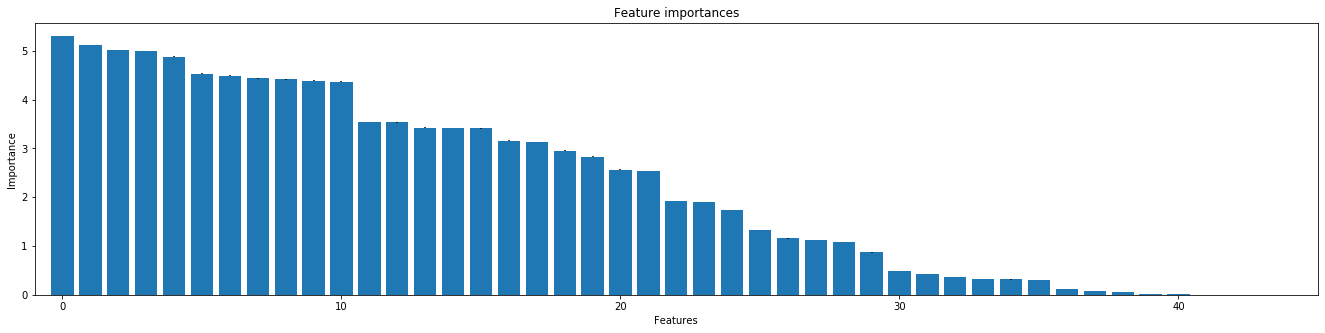

In [1148]:
# On souhaite Afficher dans un graphique notre importance

std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importance)[::-1]

# Affichage de nos features avec leur pourcentage
print("Features:")
print()

for f in range(X_wo_index0.shape[1]):
    print("%d  %s: (%f)" % (f, X_tr_wo_index0.columns[f], importance[indices[f]]*100))

# Affichage de notre Features importance
plt.figure()
plt.subplots(figsize=(23,5))                                              #Taille de la figure
plt.title("Feature importances")
plt.xlabel('Features')
plt.ylabel('Importance')
plt.bar(colNumberList, importance[indices]*100, yerr=std[indices], align="center") # Valeur en X, Hauteur, Largeur, alignement
plt.xlim([-1, X_wo_index0.shape[1]])                                                # Limite de l'axe X
plt.show()

Le graphique ci-dessus nous montrent que certaines colonnes sont beaucoup plus importantes que d'autres. En l'occurence, les colonnes qui ont le pourcentage le plus grand sont beaucoup plus nécéssaire que celle qui on un pourcentage bas afin d'avoir un résultat une accuracy précise.

## Entrainer un model

Nous souhaitons prédir la gravité d'un accident selon l'environnement qui entoure l'accident.

In [1131]:
clf = RandomForestClassifier(random_state=0)

In [1132]:
X_tr, X_te, Y_tr, Y_te = TTS(X, Y,              # features, target
                            stratify = Y,       # Va prendre une proportion aux hasard de valeurs différentes histoire de ne pas avoir des cas où l'on a que des même valeur
                            random_state=777,   # Sert à fixer le harsard pour ne pas avoir des résultat différents à chaque tests.
                            train_size=0.8)     # 80% de X_train et Y_train et 50% de Y_test et Y_test

In [1133]:
clf.fit(X_tr, Y_tr)

RandomForestClassifier(random_state=0)

In [1134]:
clf.predict(X_te)

array([2, 1, 1, ..., 1, 1, 1], dtype=int8)

In [1135]:
clf.predict_proba(X_te)

array([[0.  , 0.28, 0.6 , 0.12],
       [0.  , 0.51, 0.48, 0.01],
       [0.  , 0.75, 0.25, 0.  ],
       ...,
       [0.  , 0.51, 0.49, 0.  ],
       [0.  , 0.9 , 0.1 , 0.  ],
       [0.  , 0.86, 0.14, 0.  ]])

In [1136]:
predictions = clf.predict(X_te)

In [1137]:
# On cherche à prédir X_tr par rapport à Y_tr

knn = KNN(n_neighbors=3)
knn.fit(X_tr, Y_tr)
train_preds = knn.predict(X_te)
"TEST ACCURACY: ", accuracy(predictions, Y_te)

('TEST ACCURACY: ', 0.7559348636452815)

In [1138]:
train_preds = knn.predict(X_tr)
"TRAIN ACCURACY: ", accuracy(train_preds, Y_tr)

('TRAIN ACCURACY: ', 0.7912680892813343)

Nous pouvons voir que nous avons 78 en précision. Le résultat est intéressant mais pas satisfaisant car nous voulons pouvoir prédir avec un maximum de précision la gravité d'un accident afin de pouvoir, par la suite mieux cibler les zones qui seront touchées par des cas d'accidents avec une fortes "gravités" et donc, on plus fortes probabilités de décès.

Features:

0  Source: (5.297585)
1  TMC: (5.116218)
2  Distance(mi): (5.019457)
3  City: (4.994874)
4  County: (4.876898)
5  State: (4.529886)
6  Airport_Code: (4.488609)
7  Temperature(F): (4.431727)
8  Humidity(%): (4.412176)
9  Pressure(in): (4.388742)
10  Visibility(mi): (4.367214)
11  Wind_Speed(mph): (3.534331)
12  Precipitation(in): (3.529949)
13  Weather_Condition: (3.425145)
14  Amenity: (3.414169)
15  Bump: (3.406340)
16  Crossing: (3.159548)
17  Give_Way: (3.133396)
18  Junction: (2.949292)
19  No_Exit: (2.829993)
20  Railway: (2.558177)
21  Roundabout: (2.538598)
22  Station: (1.915319)
23  Stop: (1.897775)
24  Traffic_Calming: (1.741234)
25  Traffic_Signal: (1.330669)
26  Turning_Loop: (1.158762)
27  Sunrise_Sunset: (1.126097)
28  Civil_Twilight: (1.083857)
29  Nautical_Twilight: (0.867104)
30  Astronomical_Twilight: (0.480311)
31  Start_Time_year: (0.427326)
32  Start_Time_month: (0.359525)
33  Start_Time_week: (0.320667)
34  Start_Time_day: (0.314117)
35  Start_Time_hour

<Figure size 432x288 with 0 Axes>

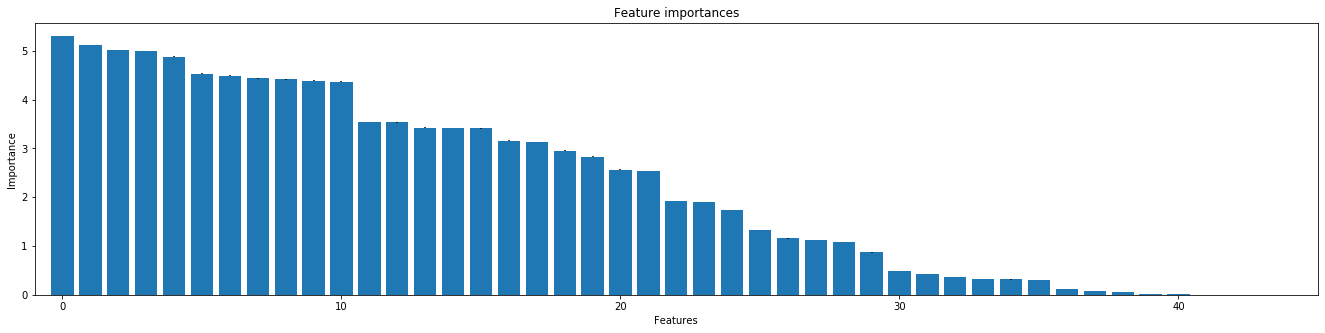

## Confusion matrix

In [1072]:
X_te.shape, Y_te.shape, X_tr.shape, Y_tr.shape

((5097, 46), (5097,), (20385, 46), (20385,))

In [1073]:
# Matrice de confusion 
#
# la matrice de confusion est une matrice qui mesure la qualité d'un système de classification. 
# Chaque ligne correspond à une classe réelle, chaque colonne correspond à une classe estimée. 

(train_preds, Y_tr)
(predictions, Y_te)

from sklearn.metrics import confusion_matrix

labels = range(4)                                             # Equivaut aux valeurs que peut retourner la target
cm_train = confusion_matrix(train_preds, Y_tr, labels=labels)
cm_test = confusion_matrix(predictions, Y_te, labels=labels)

In [1074]:
Y.unique()

array([1, 2, 0, 3], dtype=int8)

In [1075]:
labels

range(0, 4)

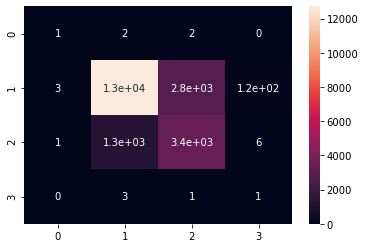

In [1076]:
show_cm(cm_train, labels)

In [1077]:
cm_train

array([[    1,     2,     2,     0],
       [    3, 12718,  2835,   117],
       [    1,  1285,  3410,     6],
       [    0,     3,     1,     1]], dtype=int64)

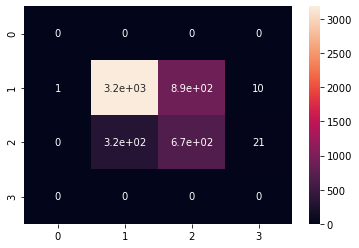

In [1078]:
show_cm(cm_test, labels)

In [1079]:
cm_test

array([[   0,    0,    0,    0],
       [   1, 3185,  894,   10],
       [   0,  318,  668,   21],
       [   0,    0,    0,    0]], dtype=int64)

Le graphique ci-dessus nous montrent que certaines colonnes sont beaucoup plus importantes que d'autres. En l'occurence, les colonnes qui ont le pourcentage le plus grand sont beaucoup plus nécéssaire que celle qui on un pourcentage bas afin d'avoir un résultat une accuracy précise.

## Affichage du nombre d'accident en fonction

In [ ]:
# L'objectif est d'afficher le Nombre d'attaque en fonction des pays
# On affichera uniquement les 10 pays les plus attaqué

accident_wo_class0 = accident[accident['class'] == 1]              # On s'interessera qu'au fraude qui on eu lieu
city_by_class = pd.DataFrame()                         # On crée un nouveau dataframe
country_by_class['country'] = fd_ip['country']            # On ajoute à notre dataset la colonne country
country_by_class['class'] = fd_ip['class']                # On ajoute à notre dataset la colonne classe
total = country_by_class.groupby(by="country",as_index=False).sum().sort_values(by='class', ascending=False) # On groupe tout nos country en en fonction de la somme de nos class par ordre décroissant

total.head(10)                                            # On affiche le total


In [ ]:
df = total.head(10)

sns.barplot(df['class'], df['country']).set_title("Nombre de fraude en fonction des pays");

# Courbe de ROC

In [744]:
# Binarize the output
Y = label_binarize(Y, classes=[0, 1, 2])
n_classes = Y.shape[1]

In [745]:
# Binarize the output
Y = label_binarize(Y, classes=[0, 1, 2])
n_classes = Y.shape[1]

In [746]:
splits = TTS(X, Y,           # features, target
                         train_size=0.3,  # 50% de X_train et Y_train et 50% de Y_test et Y_test
                         stratify=Y,      # Va prendre une proportion aux hasard de valeurs différentes histoire de ne pas avoir des cas où l'on a que des même valeur
                         random_state=1203)  # Sert à fixer le harsard pour ne pas avoir des résultat différents à chaque tests.

In [747]:
# shuffle and split training and test sets
X_train, X_test, Y_train, Y_test = splits #On associe chaque shape à une variable

In [748]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], Y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


NameError: name 'Y_score' is not defined

In [ ]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])